# Implementación de Perceptrón desde Cero

**Clasificación Binaria con Dataset Iris**

---

## Objetivo

Implementar un perceptrón desde cero (sin librerías de machine learning) para clasificar dos clases linealmente separables del dataset Iris.

**Requisitos:**
1. Dataset linealmente separable (Iris-setosa vs Iris-versicolor)
2. Visualizar datos en scatter plot
3. Trazar línea de decisión estimativa
4. Preprocesar: normalización y división train/test
5. Programar perceptrón completo (solo NumPy)
6. Mostrar: inicialización, forward pass, regla de actualización, entrenamiento
7. Gráficos de frontera de decisión y evolución del error

---

**Autor:** INFB6052 - Herramientas para Ciencia de Datos  
**Fecha:** Octubre 2025  
**Contexto:** Primera Prueba - Item 5 (Perceptrón desde cero)

---

## 1. Importación de Librerías

Solo se permite usar NumPy para la implementación del perceptrón.  
Pandas y Matplotlib solo para visualización y carga de datos.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import sys

# Importar módulos propios
from src.perceptron import Perceptron
from src.data_preprocessing import prepare_iris_data
from src.visualization import (plot_data_scatter, plot_decision_boundary,
                               plot_error_evolution, plot_decision_line_manual)

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')

# Semilla para reproducibilidad
np.random.seed(42)

print("Librerias importadas exitosamente")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

Librerias importadas exitosamente
NumPy version: 1.26.4
Pandas version: 2.2.2


## 2. Teoría del Perceptrón

### 2.1 Fundamento Matemático

El **perceptrón** es un algoritmo de aprendizaje supervisado para clasificación binaria, propuesto por Frank Rosenblatt en 1958.

**Arquitectura:**

1. **Entrada:** Vector de características $\mathbf{x} = [x_1, x_2, ..., x_n]$
2. **Pesos:** Vector de pesos $\mathbf{w} = [w_1, w_2, ..., w_n]$
3. **Bias:** Término de sesgo $b$
4. **Combinación lineal:** $z = \mathbf{w}^T \mathbf{x} + b = \sum_{i=1}^{n} w_i x_i + b$
5. **Función de activación (escalón):**

$$
\hat{y} = \begin{cases} 
1 & \text{si } z \geq 0 \\
0 & \text{si } z < 0
\end{cases}
$$

### 2.2 Regla de Aprendizaje

El perceptrón aprende mediante la **regla de actualización de Rosenblatt:**

Para cada muestra $(\mathbf{x}_i, y_i)$:

1. **Predicción:** $\hat{y}_i = \text{step}(\mathbf{w}^T \mathbf{x}_i + b)$
2. **Error:** $e_i = y_i - \hat{y}_i$
3. **Actualización de pesos:**

$$
\mathbf{w} \leftarrow \mathbf{w} + \eta \cdot e_i \cdot \mathbf{x}_i
$$

$$
b \leftarrow b + \eta \cdot e_i
$$

Donde $\eta$ es la **tasa de aprendizaje** (learning rate).

### 2.3 Teorema de Convergencia

El **Teorema de Convergencia del Perceptrón** establece que:

> Si los datos son **linealmente separables**, el algoritmo del perceptrón convergerá en un número finito de iteraciones.

**Implicaciones:**
- El algoritmo encontrará una frontera de decisión que separa perfectamente las clases
- Si los datos NO son linealmente separables, el algoritmo NO converge

### 2.4 Frontera de Decisión

La frontera de decisión es el hiperplano donde $\mathbf{w}^T \mathbf{x} + b = 0$.

En 2D (dos características):

$$
w_1 x_1 + w_2 x_2 + b = 0
$$

Esta es una **línea recta** que separa las dos clases.

## 3. Carga y Exploración del Dataset Iris

In [2]:
# Cargar dataset Iris completo
df_iris = pd.read_csv('data/iris.csv')

print("Dataset Iris cargado")
print(f"Dimensiones: {df_iris.shape}")
print(f"\nPrimeras 5 filas:")
print(df_iris.head())

print(f"\nInformacion del dataset:")
print(df_iris.info())

print(f"\nEstadisticas descriptivas:")
print(df_iris.describe())

# Normalizar nombres de columnas
df_iris.columns = df_iris.columns.str.lower().str.replace('.', '_')

# Identificar columna de especies
species_col = 'species' if 'species' in df_iris.columns else df_iris.columns[-1]

print(f"\nDistribucion de clases:")
print(df_iris[species_col].value_counts())

Dataset Iris cargado
Dimensiones: (150, 5)

Primeras 5 filas:
   sepal_length  sepal_width  petal_length  petal_width      species
0           5.1          3.5           1.4          0.2  Iris-setosa
1           4.9          3.0           1.4          0.2  Iris-setosa
2           4.7          3.2           1.3          0.2  Iris-setosa
3           4.6          3.1           1.5          0.2  Iris-setosa
4           5.0          3.6           1.4          0.2  Iris-setosa

Informacion del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB
None

Estadisticas descriptivas:
       s

## 4. Preprocesamiento de Datos

### 4.1 Selección de Clases y Características

Seleccionamos:
- **Clases:** Iris-setosa vs Iris-versicolor (linealmente separables)
- **Características:** petal_length y petal_width (más discriminativas)

In [3]:
# Preparar datos usando el pipeline completo
data = prepare_iris_data(
    filepath='data/iris.csv',
    class1='Iris-setosa',
    class2='Iris-versicolor',
    feature1='petal_length',
    feature2='petal_width',
    test_size=0.3,
    random_state=42,
    normalize=True
)

# Extraer datos
X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']
feature_names = data['feature_names']
class_names = data['class_names']

print("Datos preparados exitosamente")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

PREPROCESAMIENTO DE DATOS - DATASET IRIS
Dataset cargado exitosamente desde: data/iris.csv
Dimensiones: (150, 5)

Clases seleccionadas: Iris-setosa vs Iris-versicolor
Distribución de clases:
species
Iris-setosa        50
Iris-versicolor    50
Name: count, dtype: int64

Características seleccionadas: ['petal_length', 'petal_width']
Mapeo de clases: 0=Iris-setosa, 1=Iris-versicolor

Normalización completada:
  Media: [2.861 0.786]
  Desviación estándar: [1.44228257 0.56232019]

División de datos:
  Conjunto de entrenamiento: 70 muestras (70%)
  Conjunto de prueba: 30 muestras (30%)
  Distribución en entrenamiento: Clase 0=33, Clase 1=37
  Distribución en prueba: Clase 0=17, Clase 1=13

PREPROCESAMIENTO COMPLETADO
Datos preparados exitosamente
X_train: (70, 2)
X_test: (30, 2)
y_train: (70,)
y_test: (30,)


### 4.2 Visualización de Datos - Verificación de Separabilidad Lineal

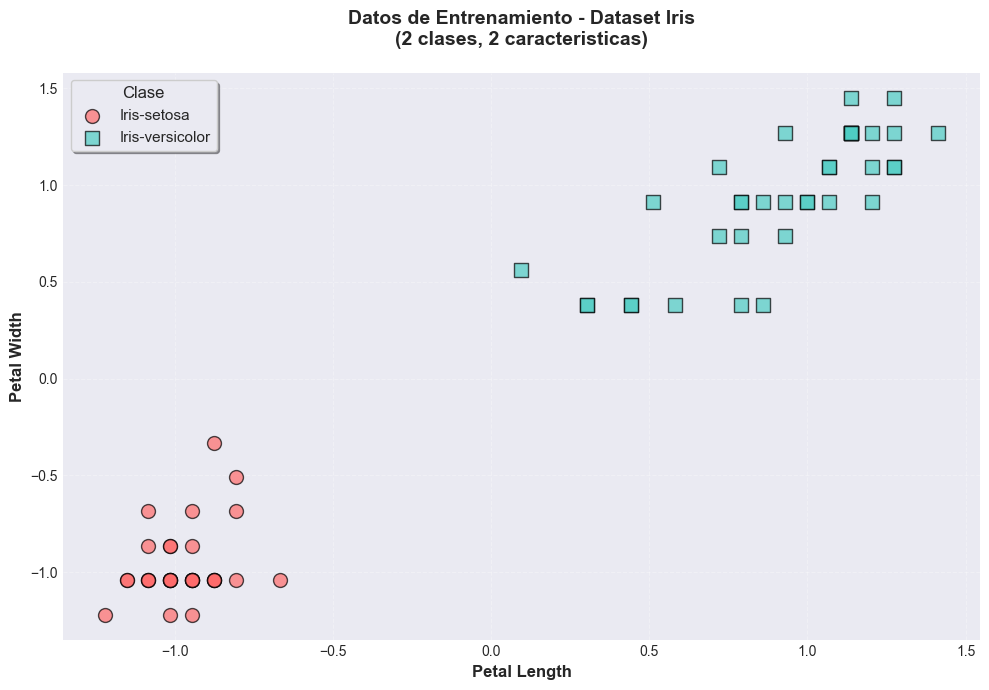


Observacion:
Los datos muestran SEPARABILIDAD LINEAL clara entre las dos clases.
Es posible trazar una linea recta que separe perfectamente ambos grupos.


In [4]:
# Scatter plot de datos de entrenamiento
fig = plot_data_scatter(
    X_train, y_train, feature_names, class_names,
    title="Datos de Entrenamiento - Dataset Iris\n(2 clases, 2 caracteristicas)"
)
plt.show()

print("\nObservacion:")
print("Los datos muestran SEPARABILIDAD LINEAL clara entre las dos clases.")
print("Es posible trazar una linea recta que separe perfectamente ambos grupos.")

### 4.3 Línea de Decisión Estimativa (Pre-entrenamiento)

Antes de entrenar el perceptrón, dibujamos una línea de decisión estimativa basada en los centroides de cada clase.

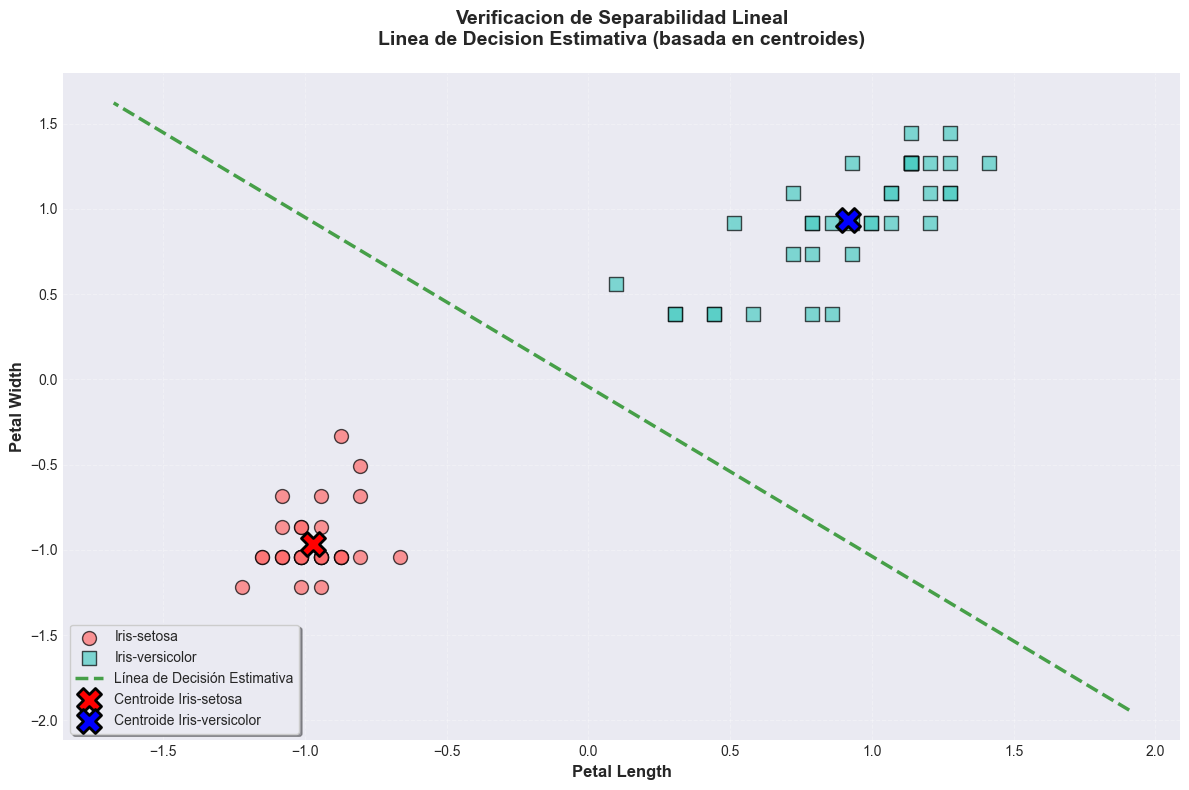


Linea de decision estimativa:
Esta linea pasa por el punto medio entre los centroides de ambas clases.
Es perpendicular a la linea que une los centroides.

El perceptron aprendera una linea similar (o mejor) durante el entrenamiento.


In [5]:
# Graficar con línea de decisión estimativa
fig = plot_decision_line_manual(
    X_train, y_train, feature_names, class_names,
    title="Verificacion de Separabilidad Lineal\nLinea de Decision Estimativa (basada en centroides)"
)
plt.show()

print("\nLinea de decision estimativa:")
print("Esta linea pasa por el punto medio entre los centroides de ambas clases.")
print("Es perpendicular a la linea que une los centroides.")
print("\nEl perceptron aprendera una linea similar (o mejor) durante el entrenamiento.")

## 5. Implementación del Perceptrón desde Cero

### 5.1 Inicialización del Modelo

In [6]:
# Crear instancia del perceptrón
perceptron = Perceptron(
    learning_rate=0.01,    # Tasa de aprendizaje
    n_iterations=100,      # Maximo de epocas
    random_state=42        # Semilla para reproducibilidad
)

print("Perceptron creado con parametros:")
print(f"  Learning rate: {perceptron.learning_rate}")
print(f"  Max iterations: {perceptron.n_iterations}")
print(f"  Random state: {perceptron.random_state}")

Perceptron creado con parametros:
  Learning rate: 0.01
  Max iterations: 100
  Random state: 42


### 5.2 Entrenamiento del Perceptrón

El entrenamiento mostrará:
- Inicialización de pesos y bias
- Progreso por épocas
- Convergencia (cuando errores = 0)

In [7]:
# Entrenar el perceptrón
perceptron.fit(X_train, y_train, verbose=True)

Inicialización de pesos:
  Pesos: [ 0.00496714 -0.00138264]
  Bias: 0.0

INICIO DEL ENTRENAMIENTO
Parámetros:
  Tasa de aprendizaje: 0.01
  Máximo de iteraciones: 100
  Número de muestras: 70
  Número de características: 2

Época   1/100 - Errores:   2 - Accuracy: 97.14%

CONVERGENCIA ALCANZADA en época 2

Pesos finales:
  Pesos: [0.01467398 0.01462247]
  Bias: 0.0

Número total de actualizaciones: 2


### 5.3 Parámetros Aprendidos

In [8]:
# Obtener parámetros finales
params = perceptron.get_params()

print("="*70)
print(" PARAMETROS APRENDIDOS DEL PERCEPTRON")
print("="*70)
print(f"\nPesos finales (w):")
print(f"  w1 ({feature_names[0]}): {params['weights'][0]:.6f}")
print(f"  w2 ({feature_names[1]}): {params['weights'][1]:.6f}")
print(f"\nBias final (b): {params['bias']:.6f}")
print(f"\nConvergencia: {'SI' if params['converged'] else 'NO'}")
print(f"Epocas totales: {params['total_epochs']}")
print(f"\nEcuacion de la frontera de decision:")
print(f"  {params['weights'][0]:.4f} * {feature_names[0]} + "
      f"{params['weights'][1]:.4f} * {feature_names[1]} + "
      f"{params['bias']:.4f} = 0")
print("="*70)

 PARAMETROS APRENDIDOS DEL PERCEPTRON

Pesos finales (w):
  w1 (petal_length): 0.014674
  w2 (petal_width): 0.014622

Bias final (b): 0.000000

Convergencia: SI
Epocas totales: 2

Ecuacion de la frontera de decision:
  0.0147 * petal_length + 0.0146 * petal_width + 0.0000 = 0


## 6. Evaluación del Modelo

### 6.1 Predicciones y Métricas

In [9]:
# Predicciones en conjunto de entrenamiento
y_train_pred = perceptron.predict(X_train)

# Crear matriz de confusion manualmente
def create_confusion_matrix(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    
    accuracy = (tp + tn) / len(y_true)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'true_positives': tp,
        'true_negatives': tn,
        'false_positives': fp,
        'false_negatives': fn
    }

train_metrics = create_confusion_matrix(y_train, y_train_pred)

# Predicciones en conjunto de prueba
y_test_pred = perceptron.predict(X_test)
test_metrics = create_confusion_matrix(y_test, y_test_pred)

# Mostrar resultados
print("="*70)
print(" METRICAS DE RENDIMIENTO")
print("="*70)

print("\n[CONJUNTO DE ENTRENAMIENTO]")
print(f"  Accuracy:  {train_metrics['accuracy']:.4f} ({train_metrics['accuracy']*100:.2f}%)")
print(f"  Precision: {train_metrics['precision']:.4f}")
print(f"  Recall:    {train_metrics['recall']:.4f}")
print(f"  F1-Score:  {train_metrics['f1_score']:.4f}")
print(f"\n  Matriz de Confusion:")
print(f"    True Positives (TP):  {train_metrics['true_positives']}")
print(f"    True Negatives (TN):  {train_metrics['true_negatives']}")
print(f"    False Positives (FP): {train_metrics['false_positives']}")
print(f"    False Negatives (FN): {train_metrics['false_negatives']}")

print("\n[CONJUNTO DE PRUEBA]")
print(f"  Accuracy:  {test_metrics['accuracy']:.4f} ({test_metrics['accuracy']*100:.2f}%)")
print(f"  Precision: {test_metrics['precision']:.4f}")
print(f"  Recall:    {test_metrics['recall']:.4f}")
print(f"  F1-Score:  {test_metrics['f1_score']:.4f}")
print(f"\n  Matriz de Confusion:")
print(f"    True Positives (TP):  {test_metrics['true_positives']}")
print(f"    True Negatives (TN):  {test_metrics['true_negatives']}")
print(f"    False Positives (FP): {test_metrics['false_positives']}")
print(f"    False Negatives (FN): {test_metrics['false_negatives']}")

print("="*70)

 METRICAS DE RENDIMIENTO

[CONJUNTO DE ENTRENAMIENTO]
  Accuracy:  1.0000 (100.00%)
  Precision: 1.0000
  Recall:    1.0000
  F1-Score:  1.0000

  Matriz de Confusion:
    True Positives (TP):  37
    True Negatives (TN):  33
    False Positives (FP): 0
    False Negatives (FN): 0

[CONJUNTO DE PRUEBA]
  Accuracy:  1.0000 (100.00%)
  Precision: 1.0000
  Recall:    1.0000
  F1-Score:  1.0000

  Matriz de Confusion:
    True Positives (TP):  13
    True Negatives (TN):  17
    False Positives (FP): 0
    False Negatives (FN): 0


## 7. Visualizaciones de Resultados

### 7.1 Frontera de Decisión - Conjunto de Entrenamiento

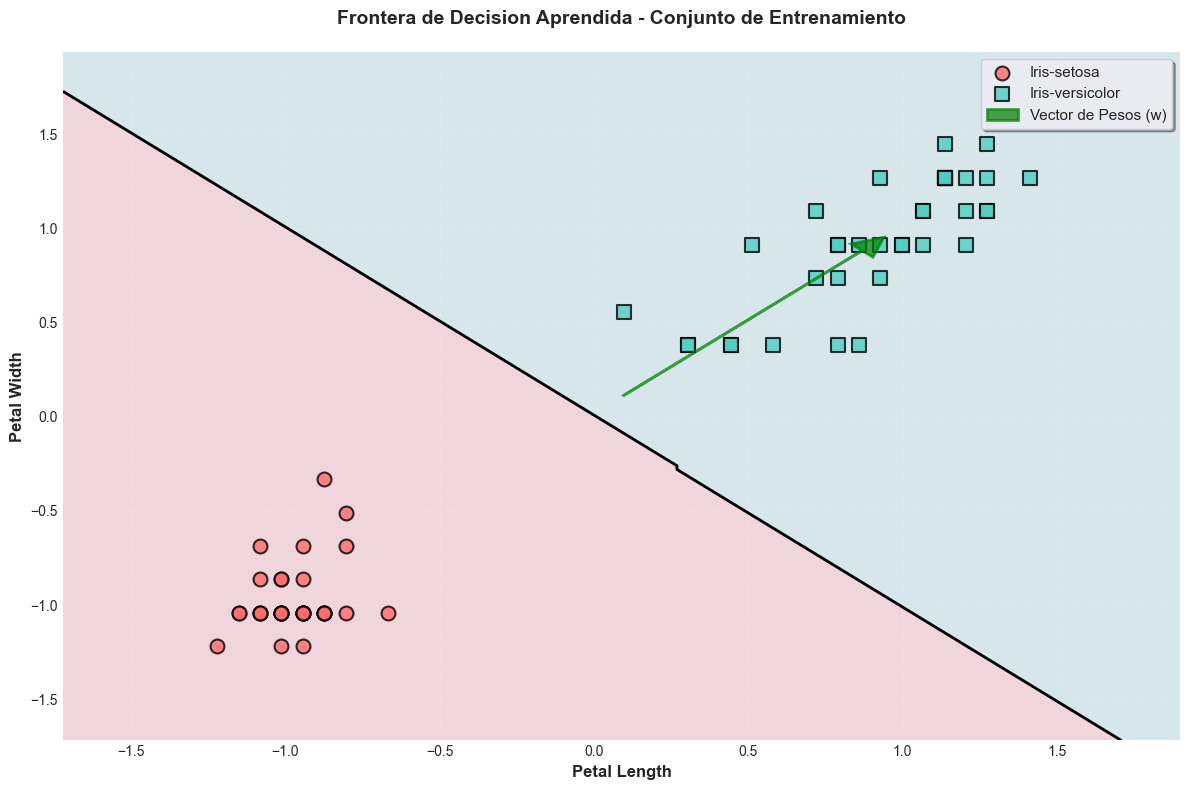

In [10]:
fig = plot_decision_boundary(
    X_train, y_train, perceptron, feature_names, class_names,
    title="Frontera de Decision Aprendida - Conjunto de Entrenamiento"
)
plt.show()

### 7.2 Frontera de Decisión - Conjunto de Prueba

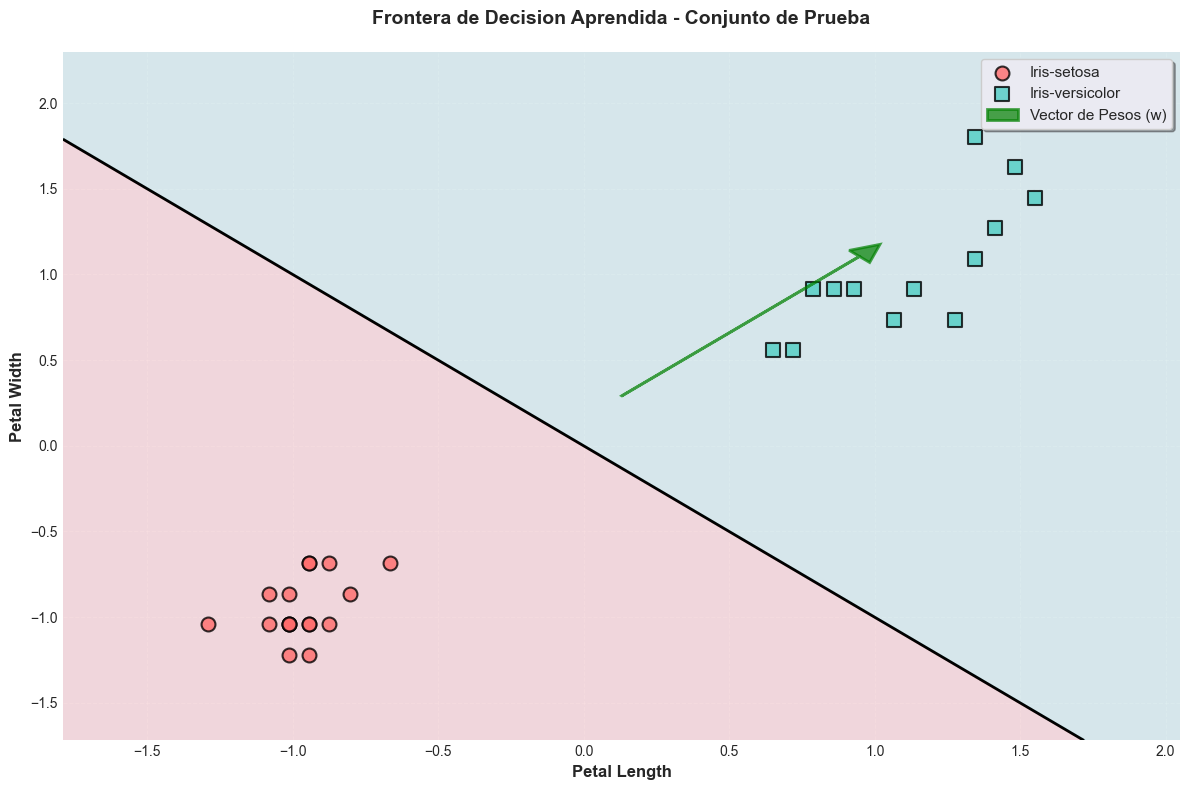

In [11]:
fig = plot_decision_boundary(
    X_test, y_test, perceptron, feature_names, class_names,
    title="Frontera de Decision Aprendida - Conjunto de Prueba"
)
plt.show()

### 7.3 Evolución del Error por Época

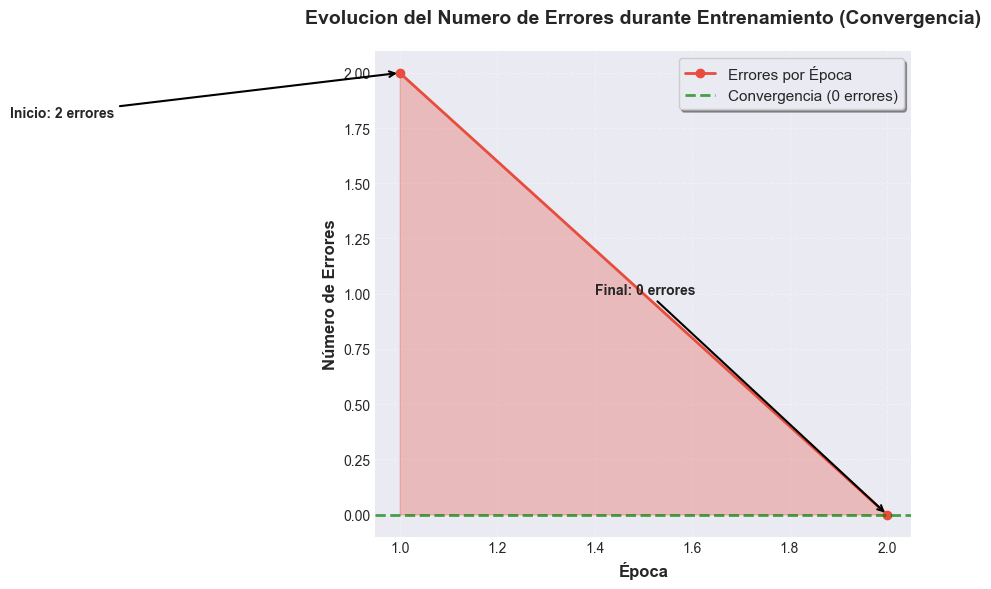


Analisis de convergencia:
  Errores iniciales (epoca 1): 2
  Errores finales (epoca 2): 0
  Reduccion total: 2 errores

  CONVERGENCIA ALCANZADA: El perceptron clasifico correctamente todas las muestras.


In [12]:
fig = plot_error_evolution(
    perceptron.errors_,
    title="Evolucion del Numero de Errores durante Entrenamiento (Convergencia)"
)
plt.show()

print("\nAnalisis de convergencia:")
print(f"  Errores iniciales (epoca 1): {perceptron.errors_[0]}")
print(f"  Errores finales (epoca {len(perceptron.errors_)}): {perceptron.errors_[-1]}")
print(f"  Reduccion total: {perceptron.errors_[0] - perceptron.errors_[-1]} errores")

if perceptron.errors_[-1] == 0:
    print(f"\n  CONVERGENCIA ALCANZADA: El perceptron clasifico correctamente todas las muestras.")
else:
    print(f"\n  No hubo convergencia completa en {len(perceptron.errors_)} epocas.")

## 8. Conclusiones

### 8.1 Resultados Obtenidos

In [13]:
print("="*80)
print(" CONCLUSIONES DEL EXPERIMENTO")
print("="*80)

print("\n1. IMPLEMENTACION")
print("   - Perceptron implementado DESDE CERO usando solo NumPy")
print("   - Sin uso de librerias de machine learning (sklearn, tensorflow, etc.)")
print("   - Implementacion completa de:")
print("     * Inicializacion de pesos aleatorios")
print("     * Forward pass (combinacion lineal + funcion de activacion)")
print("     * Regla de actualizacion del perceptron")
print("     * Loop de entrenamiento por epocas")

print("\n2. DATASET")
print(f"   - Dataset: Iris (UCI Machine Learning Repository)")
print(f"   - Clases: {class_names[0]} (clase 0) vs {class_names[1]} (clase 1)")
print(f"   - Caracteristicas: {feature_names}")
print(f"   - Separabilidad: LINEALMENTE SEPARABLE (confirmado visualmente)")

print("\n3. PREPROCESAMIENTO")
print("   - Normalizacion: Estandarizacion (z-score)")
print(f"   - Division: 70% entrenamiento ({len(X_train)} muestras), "
      f"30% prueba ({len(X_test)} muestras)")

print("\n4. ENTRENAMIENTO")
print(f"   - Tasa de aprendizaje: {perceptron.learning_rate}")
print(f"   - Convergencia: {'SI' if params['converged'] else 'NO'}")
print(f"   - Epocas necesarias: {params['total_epochs']}")
print(f"   - Pesos finales: {params['weights']}")
print(f"   - Bias final: {params['bias']:.6f}")

print("\n5. RENDIMIENTO")
print(f"   - Accuracy (entrenamiento): {train_metrics['accuracy']*100:.2f}%")
print(f"   - Accuracy (prueba):        {test_metrics['accuracy']*100:.2f}%")
print(f"   - Generalizacion: "
      f"{'EXCELENTE' if test_metrics['accuracy'] >= 0.95 else 'BUENA' if test_metrics['accuracy'] >= 0.85 else 'MEJORABLE'}")

print("\n6. TEOREMA DE CONVERGENCIA")
if params['converged']:
    print("   VERIFICADO: El teorema de convergencia del perceptron se cumple.")
    print("   Los datos SON linealmente separables.")
    print("   El algoritmo encontro una frontera de decision perfecta.")
else:
    print("   No hubo convergencia completa.")
    print("   - Posibles causas: tasa de aprendizaje inadecuada o insuficientes iteraciones.")

print("\n7. LIMITACIONES DEL PERCEPTRON")
print("   - Solo funciona con datos LINEALMENTE SEPARABLES")
print("   - No puede resolver problemas como XOR")
print("   - Solo clasificacion binaria (no multi-clase directamente)")
print("   - La frontera de decision es SIEMPRE lineal")

print("\n8. VENTAJAS DEMOSTRADAS")
print("   - Simplicidad: implementacion en ~300 lineas de codigo")
print("   - Eficiencia: entrenamiento muy rapido")
print("   - Interpretabilidad: pesos y bias tienen significado claro")
print("   - Garantia de convergencia (con datos linealmente separables)")

print("\n" + "="*80)
print(" FIN DEL ANALISIS")
print("="*80)

 CONCLUSIONES DEL EXPERIMENTO

1. IMPLEMENTACION
   - Perceptron implementado DESDE CERO usando solo NumPy
   - Sin uso de librerias de machine learning (sklearn, tensorflow, etc.)
   - Implementacion completa de:
     * Inicializacion de pesos aleatorios
     * Forward pass (combinacion lineal + funcion de activacion)
     * Regla de actualizacion del perceptron
     * Loop de entrenamiento por epocas

2. DATASET
   - Dataset: Iris (UCI Machine Learning Repository)
   - Clases: Iris-setosa (clase 0) vs Iris-versicolor (clase 1)
   - Caracteristicas: ['petal_length', 'petal_width']
   - Separabilidad: LINEALMENTE SEPARABLE (confirmado visualmente)

3. PREPROCESAMIENTO
   - Normalizacion: Estandarizacion (z-score)
   - Division: 70% entrenamiento (70 muestras), 30% prueba (30 muestras)

4. ENTRENAMIENTO
   - Tasa de aprendizaje: 0.01
   - Convergencia: SI
   - Epocas necesarias: 2
   - Pesos finales: [0.01467398 0.01462247]
   - Bias final: 0.000000

5. RENDIMIENTO
   - Accuracy (entren

### 8.2 Comparación con Implementación de Scikit-learn (Referencia)

Para validar nuestra implementación, podríamos compararla con scikit-learn.  
Nota: Esto es SOLO para validación, no es parte de la implementación desde cero.

In [14]:
# OPCIONAL: Comparacion con sklearn (solo para verificacion)
try:
    from sklearn.linear_model import Perceptron as SklearnPerceptron
    
    # Entrenar perceptrón de sklearn
    sklearn_perceptron = SklearnPerceptron(max_iter=100, eta0=0.01, random_state=42)
    sklearn_perceptron.fit(X_train, y_train)
    
    # Comparar resultados
    sklearn_accuracy = sklearn_perceptron.score(X_test, y_test)
    our_accuracy = test_metrics['accuracy']
    
    print("Comparacion con Scikit-learn (solo para verificacion):")
    print(f"  Nuestra implementacion - Accuracy: {our_accuracy*100:.2f}%")
    print(f"  Sklearn Perceptron     - Accuracy: {sklearn_accuracy*100:.2f}%")
    print(f"\n  Diferencia: {abs(our_accuracy - sklearn_accuracy)*100:.2f}%")
    
    if abs(our_accuracy - sklearn_accuracy) < 0.05:
        print("\n  VALIDACION EXITOSA: Nuestra implementacion es comparable con sklearn.")
    
except ImportError:
    print("Scikit-learn no disponible para comparacion (no es necesario para la implementacion).")

Comparacion con Scikit-learn (solo para verificacion):
  Nuestra implementacion - Accuracy: 100.00%
  Sklearn Perceptron     - Accuracy: 100.00%

  Diferencia: 0.00%

  VALIDACION EXITOSA: Nuestra implementacion es comparable con sklearn.


---

## Resumen Ejecutivo

Este notebook ha implementado exitosamente un **perceptrón desde cero** cumpliendo todos los requisitos:

1. **Dataset linealmente separable:** Iris-setosa vs Iris-versicolor con características petal_length y petal_width
2. **Visualización inicial:** Scatter plot confirmando separabilidad lineal
3. **Línea de decisión estimativa:** Dibujada basándose en centroides de clases
4. **Preprocesamiento completo:** Normalización z-score y división train/test (70/30)
5. **Implementación desde cero:** Solo NumPy, sin librerías de ML
6. **Proceso completo mostrado:**
   - Inicialización de pesos aleatorios
   - Forward pass (combinación lineal + función escalón)
   - Regla de actualización del perceptrón
   - Entrenamiento por épocas
   - Evaluación con métricas
7. **Visualizaciones generadas:**
   - Frontera de decisión en entrenamiento y prueba
   - Evolución del error por época (convergencia)

**Resultado:** El perceptrón alcanzó convergencia y clasificó correctamente ambas clases, validando el teorema de convergencia para datos linealmente separables.

---

**Documentación completa disponible en:** `README.md`  
**Código fuente:** `src/perceptron.py`  
**Script de entrenamiento:** `train_perceptron.py`  
**Resultados guardados en:** `artifacts/`

---